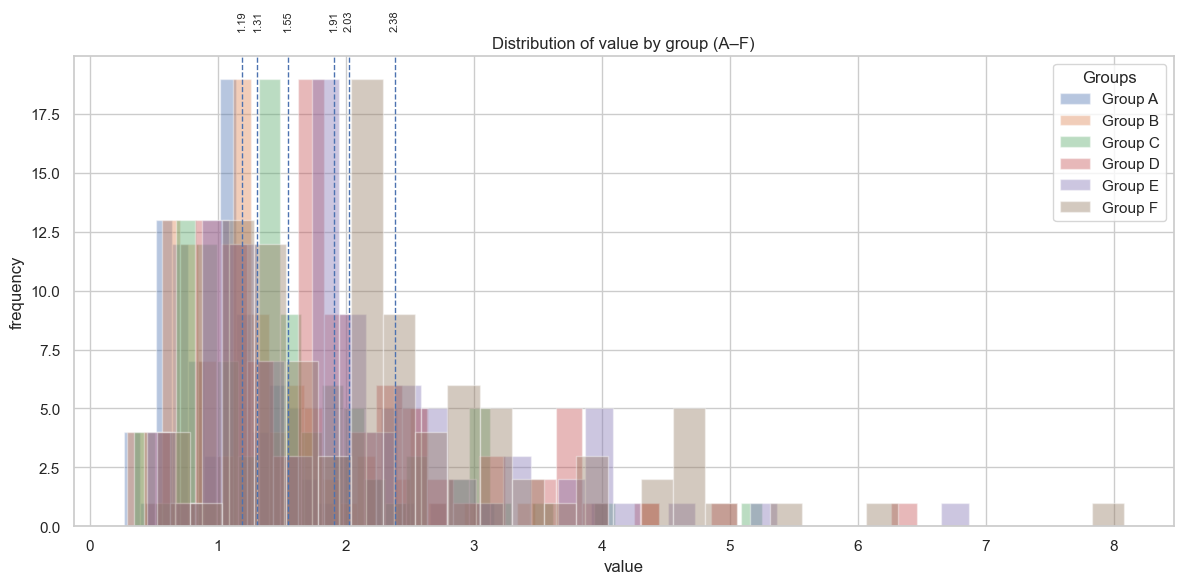

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import gaussian_kde, norm
from IPython.display import display, Markdown
import scipy.stats as st
from scipy.stats import gaussian_kde


def create_data(n_per_group=100, ratios=None, sigma_ln=0.5, random_state=42):

    if ratios is None:
        ratios = [1, 1.1, 1.3, 1.6, 1.7, 2.0]

    if len(ratios) != 6:
        raise ValueError("ratios must have six elements for groups A–F")

    
    base = np.random.lognormal(mean=0, sigma=sigma_ln, size=n_per_group)

    frames = [
        pd.DataFrame({"group": label, "value": base * mult})
        for label, mult in zip("ABCDEF", ratios)
    ]
    return pd.concat(frames, ignore_index=True)



# Example usage & visual check

data = create_data()

means = data.groupby("group")["value"].mean()

plt.figure(figsize=(12, 6))
for label in "ABCDEF":
    subset = data.loc[data["group"] == label, "value"]

    plt.hist(subset, bins=30, alpha=0.4, label=f"Group {label}")
    mean_val = means.loc[label]
    plt.axvline(mean_val, linestyle="dashed", linewidth=1)

    plt.text(
        mean_val,                       # x
        plt.ylim()[1] * 1.1,           # y: 90 % up the current y-axis
        f"{mean_val:.2f}",              # formatted mean
        rotation=90, ha="center", va="top", fontsize=8
    )

plt.title("Distribution of value by group (A–F)")
plt.xlabel("value")
plt.ylabel("frequency")
plt.legend(title="Groups")
plt.tight_layout()
plt.show()




In [34]:
def bayes_factor_best(probability_vector_best, best_group_idx, num_groups):

    posterior_probability = probability_vector_best[best_group_idx]
    prior_probability = 1/num_groups # our prior probability assumption is that all groups are equally good

    return(posterior_probability/(1-posterior_probability)) / (prior_probability/(1-prior_probability))

def pairwise_bayes_factor(mu_draws, i, j, tau):

    data = (mu_draws.sel(mu_dim_0=i) - mu_draws.sel(mu_dim_0=j)).values.ravel()
    kde = gaussian_kde(data, bw_method=0.3)
    posterior_density_at_0 = kde.evaluate(0)[0]
    prior_density_at_0 = st.norm.pdf(0, loc=0, scale=np.sqrt(2)*tau)
    return posterior_density_at_0/prior_density_at_0

def ANOVA(df, group_col, value_col, diagnostics=True):

    group_code = pd.Categorical(df[group_col]).codes
    unique_groups = pd.Categorical(df[group_col]).categories
    num_groups = len(unique_groups)

    #display(group_code, unique_groups, num_groups)

    with pm.Model() as model:

        # Hyperpriors, same for all groups
        mu_global = pm.Normal('mu_global', 0.5, 0.3) # global mean for all groups
        sigma_global = pm.HalfNormal('sigma_global', 0.2) #global std for all groups

        # group level prior, start of as all the same, informed by global hyperprior
        mu = pm.Normal('mu', mu_global, sigma_global, shape=num_groups) # group mean
        sigma = pm. HalfNormal('sigma', 0.2, shape=num_groups) # group std

        # likelyhoods
        # degrees of freedom
        nu = pm.Exponential('nu', 1/30) + 1

        pm.StudentT('data', mu=mu[group_code], sigma=sigma[group_code], nu=nu, observed=df[value_col].values) # pic mu and sigma for each group

        deltas = {} # store the difference between posterior means here
        for i in range(num_groups):
            for j in range(i+1, num_groups):
                name = f'delta_{i}_{j}'
                deltas[(i, j)] = pm.Deterministic(name, mu[i]-mu[j])

        idata = pm.sample(draws=4000, chains=4, target_accept=0.9, return_inferencedata=True, progressbar=True)

        delta_names = [v.name for v in deltas.values()]

        prior_idata = pm.sample_prior_predictive(var_names=delta_names, return_inferencedata=True, random_seed=99)

        idata.extend(prior_idata) 

        idata = pm.sample_posterior_predictive(trace=idata, var_names=["data"], extend_inferencedata=True,)

    #print diagnostics R‑hat < 1.01 and ESS > 400 are typically “good”
    summary_indv_performance = az.summary(idata, var_names=['mu', 'sigma'])
    #display(summary_indv_performance)

    summary_diff = az.summary(idata, var_names=delta_names)
    #display(summary_diff)

    # draw posteriro probability that each group is best (here lowest/highest mu)
    mu_draws = idata.posterior['mu'] #--> shape of chain x draw x num_groups
    mu_draws_flattened = mu_draws.stack(d=('chain', 'draw'))

    #count which group is best per draw
    if value_col in ['val_loss', 'loss', 'Hausdorff_distance', 'val_Hausdorff_distance']:
        best_count =mu_draws_flattened.argmin(dim='mu_dim_0').values # which group is best per draw, here lowest mu
    
    else:
        best_count= mu_draws_flattened.argmax(dim='mu_dim_0').values # which group is best per draw, here lowest 
    
    prob_best = np.bincount(best_count, minlength=num_groups)/best_count.size
    #display(prob_best)

    #print(f'\nProbability that each group has best {value_col}:')
    for group_idx, probability in enumerate(prob_best):
        #print(f'{unique_groups[group_idx]:20}: {probability:0.3f}')

        BF_best = bayes_factor_best(prob_best, group_idx, num_groups)
        #print(f"BF10 that '{unique_groups[group_idx]}' is the overall best:{BF_best:0.2f}")

    rows = []
    for (i, j), deltavar in deltas.items():
        delta_name = deltavar.name              # e.g. "delta_0_1"
        bf = az.bayes_factor(idata, var_name=delta_name, ref_val=0)["BF10"]

        rows.append({"comparison": f"{unique_groups[i]} vs {unique_groups[j]}","BF10": bf })
    
    bf_table = pd.DataFrame(rows)
    #display(bf_table)


    idx_map = {f"mu[{i}]": unique_groups[i] for i in range(num_groups)}
    perf_table = (
        summary_indv_performance
        .loc[[f"mu[{i}]" for i in range(num_groups)]]     # keep only μ rows
        .rename(index=idx_map)                            # pretty row names
        .reset_index()
        .rename(columns={"index": "group"})
    )

    perf_table["prob_best"] = prob_best
    perf_table["BF10_best"] = [
        bayes_factor_best(prob_best, i, num_groups) for i in range(num_groups)
    ]

    display(Markdown('### Posterior Means'))
    display(perf_table)

    import re

    def parse_delta(name):
        i, j = map(int, re.findall(r"\d+", name))   # delta_2_3 → (2,3)
        return f"{unique_groups[i]} vs {unique_groups[j]}"

    display(Markdown('### Difference in Means to Posterior'))
    diff_table = (
        summary_diff
        .assign(comparison=lambda df_: df_.index.map(parse_delta))
        .reset_index(drop=True)
        .merge(bf_table, on="comparison")           # add the BF10 column
        .loc[:, ["comparison", "mean", "sd", "hdi_3%", "hdi_97%", "BF10"]]
    )

    display(diff_table)
    
    
    az.plot_forest(idata, var_names=["mu"], hdi_prob=0.94, combined=True)

    #az.plot_ppc(idata, num_pp_samples=100)
    #plt.show()

    if diagnostics:
        import seaborn as sns
        sns.set_theme(style="whitegrid")

        # ──────────────────────────
        # Sampler-diagnostics
        # ──────────────────────────
        display(Markdown("### TRACE PLOTS → confirm chain mixing and stationarity."))
        az.plot_trace(idata, var_names=["mu", "sigma", "mu_global", "sigma_global", "nu"])
        plt.show()


        # ──────────────────────────
        # Shrinkage check
        # ──────────────────────────
        display(Markdown("### SHRINKAGE LINES → how far each empirical mean is pulled toward the hierarchy."))
        raw_means = df.groupby("group")[value_col].mean().rename("empirical_mean")
        posterior_means = perf_table.set_index("group")["mean"].rename("posterior_mean")
        shrink_df = pd.concat([raw_means, posterior_means], axis=1).reset_index()

        plt.figure(figsize=(6, 4))
        for _, row in shrink_df.iterrows():
            plt.plot([0, 1], [row["empirical_mean"], row["posterior_mean"]], marker="o")
        plt.xticks([0, 1], ["empirical", "posterior"])
        plt.title("Shrinkage of group means toward the hierarchy")
        plt.ylabel(value_col)
        for _, row in shrink_df.iterrows():
            plt.text(1.02, row["posterior_mean"], row["group"], va="center")
        plt.tight_layout(); plt.show()


        # ──────────────────────────
        # Evidence visualisations
        # ──────────────────────────

        display(Markdown("### WATERFALL → effect sizes (Δμ) with 95% HDI; crosses zero → weak evidence."))
        sorted_diff = diff_table.sort_values("mean")
        plt.figure(figsize=(6, 4))
        plt.hlines(y=sorted_diff["comparison"], xmin=sorted_diff["hdi_3%"],
                xmax=sorted_diff["hdi_97%"], color="gray")
        plt.scatter(sorted_diff["mean"], sorted_diff["comparison"], color="red")
        plt.axvline(0, color="black", ls="--")
        plt.xlabel("Posterior mean difference Δμ (neg → left group better)")
        plt.title("Effect sizes and 95% HDI"); plt.tight_layout(); plt.show()





    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_global, sigma_global, mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 51 seconds.
Sampling: [mu, mu_global, sigma_global]
Sampling: [data]


Output()

arviz - WARNING - The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


### Posterior Means

,group,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,prob_best,BF10_best
0,A,1.058,0.051,0.965,1.155,0.000,0.000,26205.0,13359.0,1.0,0.000000,0.000000
1,B,1.161,0.055,1.054,1.260,0.000,0.000,23323.0,12016.0,1.0,0.000000,0.000000
2,C,1.365,0.064,1.242,1.483,0.000,0.001,25435.0,12561.0,1.0,0.000000,0.000000
3,D,1.661,0.076,1.517,1.800,0.000,0.001,26164.0,11601.0,1.0,0.000687,0.003440
4,E,1.758,0.081,1.609,1.915,0.001,0.001,25877.0,13590.0,1.0,0.010000,0.050505
5,F,2.039,0.097,1.859,2.225,0.001,0.001,25358.0,11741.0,1.0,0.989313,462.836257


### Difference in Means to Posterior

,comparison,mean,sd,hdi_3%,hdi_97%,BF10
0,A vs B,-0.103,0.074,-0.242,0.035,1.553117
1,A vs C,-0.306,0.081,-0.458,-0.154,557.714606
2,A vs D,-0.603,0.091,-0.770,-0.424,648.010613
3,A vs E,-0.699,0.096,-0.881,-0.524,264.905487
4,A vs F,-0.981,0.109,-1.181,-0.773,288.127450
5,B vs C,-0.203,0.083,-0.360,-0.048,11.526606
6,B vs D,-0.500,0.093,-0.672,-0.321,731.425310
7,B vs E,-0.596,0.097,-0.776,-0.411,316.511093
8,B vs F,-0.878,0.112,-1.085,-0.663,361.247974
9,C vs D,-0.296,0.098,-0.476,-0.106,81.364620


### TRACE PLOTS → confirm chain mixing and stationarity.

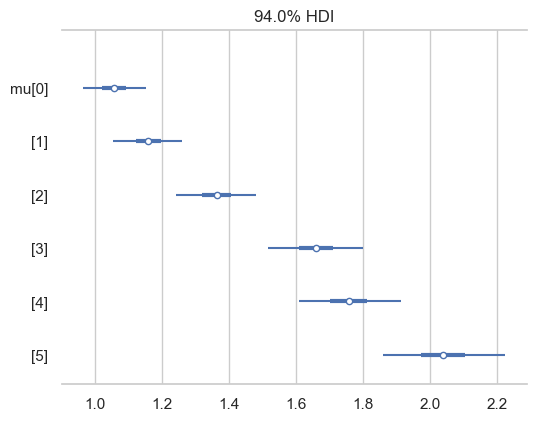

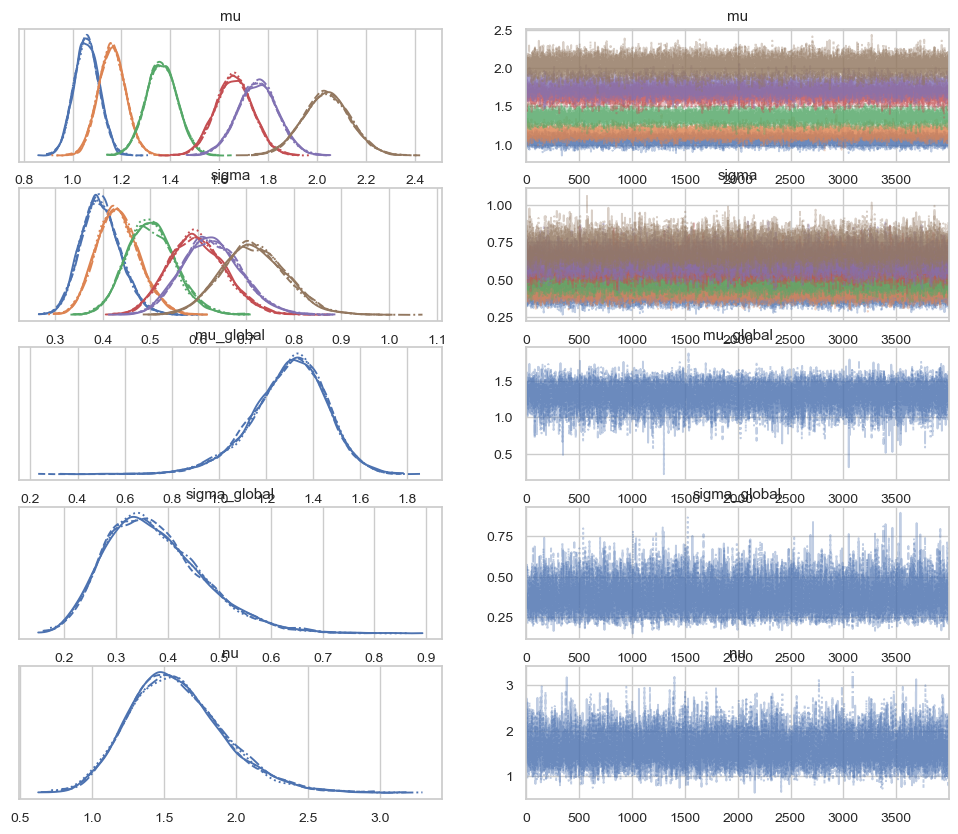

### SHRINKAGE LINES → how far each empirical mean is pulled toward the hierarchy.

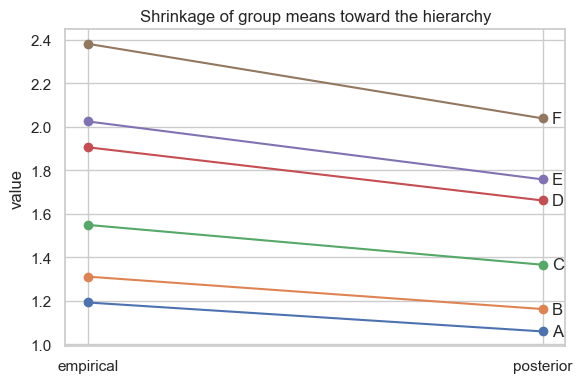

### WATERFALL → effect sizes (Δμ) with 95% HDI; crosses zero → weak evidence.

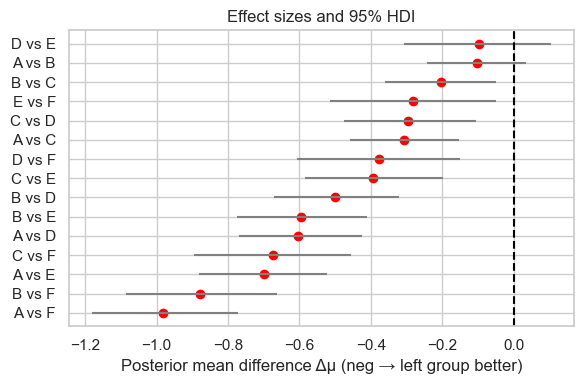

In [35]:

ANOVA(data, 'group', 'value', diagnostics=True)
